In [1]:
using Pkg
Pkg.activate("/kuacc/users/ckorkmaz16/HiSD.jl/")

  Activating environment at `~/HiSD.jl/Project.toml`


In [33]:
Pkg.add(["NNlib"])

   Resolving package versions...
    Updating `/scratch/users/ckorkmaz16/HiSD.jl/Project.toml`
  [872c559c] + NNlib v0.7.29
  No Changes to `/scratch/users/ckorkmaz16/HiSD.jl/Manifest.toml`


In [2]:
include("data.jl")
using .Data
include("transformations.jl")
using .Transformations
include("utils.jl")
using .Utils

In [3]:
using Images, Interpolations
using Images.FileIO
using Statistics
using Dates
using TensorBoardLogger, Logging, Random
using FileIO
using CUDA
using Knet

In [4]:
DATA_ROOT = "/kuacc/users/ckorkmaz16/HiSD_out"
CONFIG_FILE = "/kuacc/users/ckorkmaz16/HiSD.jl/configs/celeba-hq.yaml"

config = Utils.load_config(CONFIG_FILE)
println("Loaded config")

Loaded config


In [28]:
datasets = Utils.get_train_datasets(config, DATA_ROOT)
println("Loaded $(sum(length.(datasets))) datasets")
(x,y),i = iterate(datasets[1][1], 0)
size(x), size(y), i, typeof(x), typeof(y)

Loaded 7 datasets


((128, 128, 3, 8), (2, 8), 8, KnetArray{Float32, 4}, Knet.KnetArrays.KnetMatrix{Float32})

In [89]:
function show_image(x, i)
    xs = x[:,:,:,i:i]
    xs = permutedims(xs, [4, 3, 1, 2])
    image = reshape(xs, size(xs)[2:end]...)
    image = convert(Array, image)    
    image = image .* 0.5 .+ 0.5
    image = clamp.(image, 0.0, 1.0)
    image = image .|> N0f8 |> colorview(RGB)
    image 
end

show_image (generic function with 1 method)

In [82]:
module Network

using Knet
include("primitives.jl")
using .Primitives

export DownBlock
struct DownBlock; conv1; conv2; sc; activ; end
DownBlock(in_ch::Int,out_ch::Int) = 
    DownBlock(Conv(in_ch, in_ch, 3, 1), Conv(in_ch, out_ch, 3, 1), Conv(in_ch, out_ch, 1, 0, bias=false), LeakyRelu(0.2))
function (d::DownBlock)(x)
    residual = avg_pool2d(d.sc(x), 2)
    out = d.conv2(d.activ(avg_pool2d(d.conv1(d.activ(x)), 2)))
    return (residual + out) / sqrt(2)  
end

export DownBlockIN
struct DownBlockIN; conv1; conv2; in1; in2; sc; activ; end
DownBlockIN(in_ch::Int,out_ch::Int) = 
    DownBlockIN(Conv(in_ch, in_ch, 3, 1), Conv(in_ch, out_ch, 3, 1), 
                InstanceNorm2d(in_ch), InstanceNorm2d(in_ch),
                Conv(in_ch, out_ch, 1, 0, bias=false), LeakyRelu(0.2))
function (d::DownBlockIN)(x)
    residual = avg_pool2d(d.sc(x), 2)
    out = d.conv2(d.activ(d.in2(avg_pool2d(d.conv1(d.activ(d.in1(x))), 2))))
    return (residual + out) / sqrt(2)  
end

export UpBlock
struct UpBlock; conv1; conv2; sc; activ; end
UpBlock(in_ch::Int,out_ch::Int) = 
    UpBlock(Conv(in_ch, out_ch, 3, 1), Conv(out_ch, out_ch, 3, 1), Conv(in_ch, out_ch, 1, 0, bias=false), LeakyRelu(0.2))
function (d::UpBlock)(x)
    residual = upsample2d(d.sc(x), 2)
    out = d.conv2(d.activ(d.conv1(upsample2d(d.activ(x), 2))))
    return (residual + out) / sqrt(2)  
end

export UpBlockIn
struct UpBlockIn; conv1; conv2; in1; in2; sc; activ; end
UpBlockIn(in_ch::Int,out_ch::Int) = 
    UpBlockIn(Conv(in_ch, out_ch, 3, 1), Conv(out_ch, out_ch, 3, 1), 
              InstanceNorm2d(in_ch), InstanceNorm2d(out_ch),
              Conv(in_ch, out_ch, 1, 0, bias=false), LeakyRelu(0.2))
function (d::UpBlockIn)(x)
    residual = upsample2d(d.sc(x), 2)
    out = d.conv2(d.activ(d.in2(d.conv1(upsample2d(d.activ(d.in1(x)), 2)))))
    return (residual + out) / sqrt(2)  
end


export MiddleBlock, num_adain_params, assign_adain_params
struct MiddleBlock; conv1; conv2; adain1; adain2; sc; activ; end
MiddleBlock(in_ch::Int,out_ch::Int) = 
    MiddleBlock(Conv(in_ch, out_ch, 3, 1), Conv(out_ch, out_ch, 3, 1), 
                AdaptiveInstanceNorm2d(in_ch), AdaptiveInstanceNorm2d(out_ch),
                Conv(in_ch, out_ch, 1, 0, bias=false), LeakyRelu(0.2))
function (d::MiddleBlock)(x)
    residual = d.sc(x)
    out = d.conv2(d.activ(d.adain2(d.conv1(d.activ(d.adain1(x))))))
    return (residual + out) / sqrt(2)  
end
Primitives.num_adain_params(d::MiddleBlock) = num_adain_params(d.adain1) + num_adain_params(d.adain2)
function Primitives.assign_adain_params(d::MiddleBlock, params)
    params = assign_adain_params(d.adain1, params)
    params = assign_adain_params(d.adain2, params)
    return params
end

#TODO: Extractor, Translator and Mapper
#TODO: Generator, Discriminator

end

using .Network

In [83]:
c = Network.Chain(
    Network.DownBlock(3, 32),
    Network.MiddleBlock(32, 32),
    Network.UpBlock(32, 3)
)

Main.Network.Primitives.Chain((Main.Network.DownBlock(Main.Network.Primitives.Conv(P(KnetArray{Float32, 4}(3,3,3,3)), P(KnetArray{Float32, 4}(1,1,3,1)), 1, 1), Main.Network.Primitives.Conv(P(KnetArray{Float32, 4}(3,3,3,32)), P(KnetArray{Float32, 4}(1,1,32,1)), 1, 1), Main.Network.Primitives.Conv(P(KnetArray{Float32, 4}(1,1,3,32)), nothing, 0, 1), Main.Network.Primitives.LeakyRelu(0.2)), Main.Network.MiddleBlock(Main.Network.Primitives.Conv(P(KnetArray{Float32, 4}(3,3,32,32)), P(KnetArray{Float32, 4}(1,1,32,1)), 1, 1), Main.Network.Primitives.Conv(P(KnetArray{Float32, 4}(3,3,32,32)), P(KnetArray{Float32, 4}(1,1,32,1)), 1, 1), Main.Network.Primitives.AdaptiveInstanceNorm2d(nothing, nothing, 32, 1.0e-5), Main.Network.Primitives.AdaptiveInstanceNorm2d(nothing, nothing, 32, 1.0e-5), Main.Network.Primitives.Conv(P(KnetArray{Float32, 4}(1,1,32,32)), nothing, 0, 1), Main.Network.Primitives.LeakyRelu(0.2)), Main.Network.UpBlock(Main.Network.Primitives.Conv(P(KnetArray{Float32, 4}(3,3,32,3)), P(

In [86]:
adain_params = convert(Knet.atype(), zeros(Network.num_adain_params(c.layers[2]), config["batch_size"]))
Network.assign_adain_params(c.layers[2], adain_params)


128×8 Knet.KnetArrays.KnetMatrix{Float32}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮         
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0


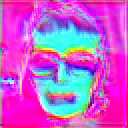

In [94]:
show_image(c(x), 1)